In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.6.0+cu124


In [ ]:
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.8 MB/s eta 0:00:00


In [2]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch
# import util
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from numpy import asarray
import tifffile as tiff
import torch.nn as nn
import torch.nn.functional as nnFn
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.manifold import TSNE
import random
from torch_geometric.nn import GATConv
import copy

In [3]:
# === Load Patients ===
fa_patients_path = "/home/snu/Downloads/NIFD_Patients_FA_Histogram_Feature.npy"
Patients_FA_array = np.load(fa_patients_path, allow_pickle=True)

# === Load Controls ===
fa_controls_path = "/home/snu/Downloads/NIFD_Control_FA_Histogram_Feature.npy"
Controls_FA_array = np.load(fa_controls_path, allow_pickle=True)

print("Patients Shape:", Patients_FA_array.shape)
print("Controls Shape:", Controls_FA_array.shape)

# === Combine features and labels ===
X = np.vstack([Controls_FA_array, Patients_FA_array])
y = np.hstack([
    np.zeros(Controls_FA_array.shape[0], dtype=np.int64),  # 0 = Control
    np.ones(Patients_FA_array.shape[0], dtype=np.int64)    # 1 = Patient
])

# Shuffle
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]

Patients Shape: (98, 180)
Controls Shape: (48, 180)


## 1 layer

In [4]:
def sim(h1, h2, tau = 0.2):
    z1 = nnFn.normalize(h1, dim=-1, p=2)
    z2 = nnFn.normalize(h2, dim=-1, p=2)
    return torch.mm(z1, z2.t()) / tau

def contrastive_loss_wo_cross_network(h1, h2, z):
    f = lambda x: torch.exp(x)
    intra_sim = f(sim(h1, h1))
    inter_sim = f(sim(h1, h2))
    return -torch.log(inter_sim.diag() /
                     (intra_sim.sum(dim=-1) + inter_sim.sum(dim=-1) - intra_sim.diag()))

def contrastive_loss_wo_cross_view(h1, h2, z):
    f = lambda x: torch.exp(x)
    cross_sim = f(sim(h1, z))
    return -torch.log(cross_sim.diag() / cross_sim.sum(dim=-1))

In [5]:
class MLP(nn.Module):
    def __init__(self, inp_size, outp_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inp_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ELU(), # nn.ELU()
            nn.Dropout(0.3),
            nn.Linear(hidden_size, outp_size)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
class GATEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, device, activ, heads=2):
        super(GATEncoder, self).__init__()
        self.device = device
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, concat=False)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.mlp = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = self.dropout(x)
        x = self.batchnorm(x)
        logits = self.mlp(x)
        return logits

In [7]:
class EMA(): # Moving Average update

    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        # old: old model parameter
        # new: new model parameter
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

In [8]:
class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_clusters, device, activ, moving_average_decay=0.5, cut=True):
        super(GAT, self).__init__()
        self.device = device
        self.num_clusters = num_clusters
        self.cut = cut
        self.beta = 0.6

        self.online_encoder = GATEncoder(input_dim, hidden_dim, device, activ)
        self.target_encoder = copy.deepcopy(self.online_encoder)

        activations = {
            "SELU": nnFn.selu,
            "SiLU": nnFn.silu,
            "GELU": nnFn.gelu,
            "RELU": nnFn.relu
        }
        self.act = activations.get(activ, nnFn.elu)

        self.online_predictor = MLP(hidden_dim, num_clusters, hidden_dim)

        self.loss = self.cut_loss if cut else self.modularity_loss
        self.target_ema_updater = EMA(moving_average_decay)

    def reset_moving_average(self):
        del self.target_encoder
        self.target_encoder = None

    def update_ma(self):
        assert self.target_encoder is not None, 'target encoder has not been created yet'
        update_moving_average(self.target_ema_updater, self.target_encoder, self.online_encoder)

    def forward(self, data1, data2):
        x1 = self.online_encoder(data1)
        logits1 = self.online_predictor(x1)
        S1 = nnFn.softmax(logits1, dim=1)

        x2 = self.online_encoder(data2)
        logits2 = self.online_predictor(x2)
        S2 = nnFn.softmax(logits2, dim=1)

        with torch.no_grad():
            target_proj_one = self.target_encoder(data1).detach()
            target_proj_two = self.target_encoder(data2).detach()

        # losses (assuming your contrastive functions are defined elsewhere)
        l1 = self.beta * contrastive_loss_wo_cross_network(x1, x2, target_proj_two) + \
             (1.0 - self.beta) * contrastive_loss_wo_cross_view(x1, x2, target_proj_two)

        l2 = self.beta * contrastive_loss_wo_cross_network(x2, x1, target_proj_one) + \
             (1.0 - self.beta) * contrastive_loss_wo_cross_view(x2, x1, target_proj_one)

        return S1, S2, logits1, logits2, l1, l2

    def modularity_loss(self, A, S):
        C = nnFn.softmax(S, dim=1)
        d = torch.sum(A, dim=1)
        m = torch.sum(A)
        B = A - torch.ger(d, d) / (2 * m)

        I_S = torch.eye(self.num_clusters, device=self.device)
        k = torch.norm(I_S)
        n = S.shape[0]

        modularity_term = (-1 / (2 * m)) * torch.trace(torch.mm(torch.mm(C.t(), B), C))
        collapse_reg_term = (torch.sqrt(k) / n) * torch.norm(torch.sum(C, dim=0), p='fro') - 1

        return modularity_term + collapse_reg_term

    def cut_loss(self, A, S):
        S = nnFn.softmax(S, dim=1)
        A_pool = torch.matmul(torch.matmul(A, S).t(), S)
        num = torch.trace(A_pool)

        D = torch.diag(torch.sum(A, dim=-1))
        D_pooled = torch.matmul(torch.matmul(D, S).t(), S)
        den = torch.trace(D_pooled)
        mincut_loss = -(num / den)

        St_S = torch.matmul(S.t(), S)
        I_S = torch.eye(self.num_clusters, device=self.device)
        ortho_loss = torch.norm(St_S / torch.norm(St_S) - I_S / torch.norm(I_S))

        return mincut_loss + ortho_loss

In [9]:
def delete_row_col(input_matrix, drop_list, only_row=False):
    remain_list = [i for i in range(input_matrix.shape[0]) if i not in drop_list]
    out = input_matrix[remain_list, :]
    if only_row:
        return out
    out = out[:, remain_list]
    return out

In [10]:
def aug_random_edge(adj_matrix, drop_percent=0.2, seed=None):
    """Randomly drops edges in adjacency matrix."""
    rng = np.random.default_rng(seed)
    adj = adj_matrix.copy()
    mask = rng.random(adj.shape) < drop_percent
    adj[mask] = 0
    return adj

In [11]:
def aug_drop_node(input_fea, input_adj, drop_percent=0.2):
    input_adj = torch.tensor(input_adj.todense().tolist())
    input_fea = input_fea.squeeze(0)
    node_num = input_fea.shape[0]
    drop_num = int(node_num * drop_percent)
    all_node_list = list(range(node_num))
    drop_node_list = sorted(random.sample(all_node_list, drop_num))
    aug_input_fea = delete_row_col(input_fea, drop_node_list, only_row=True)
    aug_input_adj = delete_row_col(input_adj, drop_node_list)
    aug_input_fea = aug_input_fea.unsqueeze(0)
    aug_input_adj = sp.csr_matrix(np.matrix(aug_input_adj))
    return aug_input_fea, aug_input_adj

In [12]:
def aug_subgraph(input_fea, input_adj, drop_percent=0.2):
    input_adj = torch.tensor(input_adj.todense().tolist())

    # If input_fea has batch dimension of 1, squeeze it
    if input_fea.ndim == 3 and input_fea.shape[0] == 1:
        input_fea = input_fea.squeeze(0)
    elif input_fea.ndim == 1:
        input_fea = input_fea.unsqueeze(1)  # ensure 2D

    node_num = input_fea.shape[0]
    all_node_list = list(range(node_num))
    s_node_num = int(node_num * (1 - drop_percent))
    center_node_id = random.randint(0, node_num - 1)
    sub_node_id_list = [center_node_id]
    all_neighbor_list = []

    for i in range(s_node_num - 1):
        all_neighbor_list += torch.nonzero(input_adj[sub_node_id_list[i]], as_tuple=False).squeeze(1).tolist()
        all_neighbor_list = list(set(all_neighbor_list))
        new_neighbor_list = [n for n in all_neighbor_list if n not in sub_node_id_list]
        if len(new_neighbor_list) != 0:
            new_node = random.sample(new_neighbor_list, 1)[0]
            sub_node_id_list.append(new_node)
        else:
            break

    drop_node_list = sorted([i for i in all_node_list if i not in sub_node_id_list])
    aug_input_fea = delete_row_col(input_fea, drop_node_list, only_row=True)
    aug_input_adj = delete_row_col(input_adj, drop_node_list)
    aug_input_fea = torch.from_numpy(aug_input_fea).unsqueeze(0)  # Convert to tensor and then unsqueeze
    aug_input_adj = sp.csr_matrix(np.matrix(aug_input_adj))
    return aug_input_fea, aug_input_adj

In [13]:
def aug_feature_dropout(features, drop_percent=0.2, seed=None):
    """Randomly drops features of nodes (column-wise)."""
    rng = np.random.default_rng(seed)
    mask = rng.random(features.shape) >= drop_percent
    return features * mask.astype(np.float32)


In [14]:
def aug_feature_dropout_cell(features, drop_percent=0.2):
    """Randomly drops individual cells in the feature matrix."""
    aug_feat = copy.deepcopy(features.squeeze(0))
    input_feat_dim = aug_feat.shape[1]
    num_nodes = aug_feat.shape[0]
    drop_feat_num = int(num_nodes * input_feat_dim * drop_percent)

    position = []
    number_list = list(range(input_feat_dim))
    for i in range(num_nodes):
        number_i = [i for _ in range(input_feat_dim)]
        position += list(zip(number_i, number_list))

    drop_idx = random.sample(position, drop_feat_num)
    for i, j in drop_idx:
        aug_feat[i, j] = 0.0
    return aug_feat

In [15]:
def aug_random_mask(features, drop_percent=0.2):
    node_num = features.shape[1]
    mask_num = int(node_num * drop_percent)
    mask_idx = random.sample(range(node_num), mask_num)
    aug_feature = copy.deepcopy(features)
    zeros = torch.zeros_like(aug_feature[0][0])
    for j in mask_idx:
        aug_feature[0][j] = zeros
    return aug_feature

In [16]:
import scipy.sparse as sp
def gdc(A: sp.csr_matrix, alpha: float = 0.05, eps: float = 1e-4):
    N = A.shape[0]
    A_loop = sp.eye(N) + A
    D_loop_vec = A_loop.sum(0).A1
    D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec)
    D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
    T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt
    S = alpha * sp.linalg.inv(sp.eye(N) - (1 - alpha) * T_sym)
    S_tilde = S.multiply(S >= eps)
    D_tilde_vec = S_tilde.sum(0).A1
    T_S = S_tilde / D_tilde_vec
    return T_S

# Adjacency Matrix creation

In [17]:
def create_adj(F, cut, alpha=1):
    # row_norms = np.linalg.norm(F, axis=1)
    # row_norms = row_norms.reshape(-1, 1)  why are we doing this?

    F_norm = F / np.linalg.norm(F, axis=1, keepdims=True)
    W = np.dot(F_norm, F_norm.T)
    # Wsa = get_wsa(F, epochs=100)
    # W = W + 0.2* Wsa

    # if NCut
    if cut == 0:
        # threshold
        # W = (W >= 0.1).astype(np.float32)
        ### Here alpha will act like threshold
        W = np.where(W >= alpha, 1, 0).astype(np.float32)
        #W = (W * (W >= alpha)).astype(np.float32)  # Preserve weighted connections
        # # norm
        W = (W / W.max()).astype(np.float32)
        # print(np.unique(W, return_counts = True))
    # if CC
    else:
        W = W - (W.max() / alpha)

    return W

# Get Edge Index from Adjacency Matrix

In [18]:
def load_data(adj, node_feats):
    """
    Load data to pytorch-geometric data format
    @param adj: Adjacency matrix of a graph (NumPy array or scipy.sparse)
    @param node_feats: Feature matrix of a graph (NumPy array or torch.Tensor)
    @return: PyG format tensors
    """
    # Convert features to torch tensor if needed
    if isinstance(node_feats, np.ndarray):
        node_feats = torch.from_numpy(node_feats).float()
    elif isinstance(node_feats, torch.Tensor):
        node_feats = node_feats.float()

    # Convert adjacency to NumPy array
    if isinstance(adj, sp.csr_matrix):
        adj = adj.toarray()
    elif isinstance(adj, torch.Tensor):
        adj = adj.cpu().numpy()

    edge_index = torch.from_numpy(np.array(np.nonzero((adj > 0)))).long()
    row, col = edge_index
    edge_weight = np.atleast_1d(adj[row, col])   # ensure array
    edge_weight = torch.from_numpy(edge_weight.astype(np.float32))

    return node_feats, edge_index, edge_weight


# Data Loading and preprocessing

In [19]:
print(X.shape)
print(y.shape)

(146, 180)
(146,)


In [20]:
features = X
#features = np.concatenate((Histogram_feature_CN_FA_array, Histogram_feature_MCI_FA_array), axis=0)
features = features.astype(np.float32)
print(features.shape, features.dtype)

(146, 180) float32


In [21]:
# Required Parameters
cut = 0  # Consider n-cut loss OR Modularity loss
alpha = 0.5 # Edge creation Threshold
device = 'cuda' if torch.cuda.is_available() else 'cpu'
feats_dim = 180  # 20-bin
K = 2  # Number of clusters
epoch = [2500, 60, 100]  # Training epochs for different phases

# Define all activation functions to test
define_activations = ["SELU", "SiLU", "GELU", "ELU", "RELU"]
activ = "ELU"

In [22]:
print(features.shape)

(146, 180)


In [23]:
F_norm = features / np.linalg.norm(features, axis=1, keepdims=True)
W = np.dot(F_norm, F_norm.T)
print(np.array(np.nonzero(W>0.6)).shape)

(2, 20520)


In [24]:
F_norm = features / np.linalg.norm(features, axis=1, keepdims=True)
W = np.dot(F_norm, F_norm.T)
print(W)

[[0.99999994 0.8497284  0.90970075 ... 0.8536243  0.85516846 0.87134004]
 [0.8497284  0.9999999  0.89257383 ... 0.8011868  0.8645267  0.86090064]
 [0.90970075 0.89257383 1.0000001  ... 0.8730685  0.8966978  0.92472154]
 ...
 [0.8536243  0.8011868  0.8730685  ... 1.0000001  0.8663177  0.903542  ]
 [0.85516846 0.8645267  0.8966978  ... 0.8663177  1.         0.9069954 ]
 [0.87134004 0.86090064 0.92472154 ... 0.903542   0.9069954  1.0000004 ]]


In [25]:
W0 = create_adj(features, cut, alpha)  # symmetric adjacency
A1 = torch.from_numpy(W0).float().to(device)  # for unsupervised loss

node_feats, edge_index, edge_weight = load_data(W0, features)
data0 = Data(x=node_feats, edge_index=edge_index, edge_attr=edge_weight).to(device)

print(data0)

Data(x=[146, 180], edge_index=[2, 21256], edge_attr=[21256])


# Model initialization

## Contrastive Loss

In [ ]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
import torch.nn as nn

model = GAT(feats_dim, 512, K, device, activ, cut).to(device)
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=200, gamma=0.5)
criterion = nn.CrossEntropyLoss()

num_epochs = 5000
lambda_contrastive = 0.005
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
for epoch in range(num_epochs):

    # Augmentation for adjacency
    W_aug1 = aug_random_edge(W0, drop_percent=0.2, seed=epoch)  # drop edges
    W_aug2 = aug_subgraph(features, sp.csr_matrix(W0), drop_percent=0.2)[1]  # subgraph

    # Augmentation for features
    features_aug1 = aug_feature_dropout(features, drop_percent=0.2, seed=epoch)
    features_aug2 = aug_feature_dropout_cell(torch.from_numpy(features), drop_percent=0.2).numpy()

    # Load data for PyG
    node_feats1, edge_index1, _ = load_data(W_aug1, features_aug1)
    node_feats2, edge_index2, _ = load_data(W_aug2, features_aug2)
    data1 = Data(x=node_feats1, edge_index=edge_index1).to(device)
    data2 = Data(x=node_feats2, edge_index=edge_index2).to(device)

    model.train()
    optimizer.zero_grad()

    S1, S2, logits1, logits2, l1, l2 = model(data1, data2)

    unsup_loss = model.loss(A1, logits1)
    cont_loss = ((l1 + l2) / 2).mean()
    total_loss = unsup_loss + lambda_contrastive * cont_loss

    total_loss.backward()
    optimizer.step()
    scheduler.step()
    model.update_ma()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Total: {total_loss:.4f} | Unsup: {unsup_loss:.4f} | Cont: {cont_loss:.4f}")

Epoch 0 | Total: -0.2128 | Unsup: -0.2401 | Cont: 5.4472
Epoch 100 | Total: -0.4525 | Unsup: -0.4803 | Cont: 5.5634
Epoch 200 | Total: -0.4559 | Unsup: -0.4846 | Cont: 5.7319
Epoch 300 | Total: -0.4535 | Unsup: -0.4820 | Cont: 5.6959
Epoch 400 | Total: -0.4540 | Unsup: -0.4821 | Cont: 5.6231
Epoch 500 | Total: -0.4526 | Unsup: -0.4812 | Cont: 5.7189
Epoch 600 | Total: -0.4483 | Unsup: -0.4766 | Cont: 5.6597
Epoch 700 | Total: -0.4236 | Unsup: -0.4515 | Cont: 5.5784
Epoch 800 | Total: -0.4528 | Unsup: -0.4808 | Cont: 5.5874
Epoch 900 | Total: -0.4586 | Unsup: -0.4864 | Cont: 5.5662
Epoch 1000 | Total: -0.4539 | Unsup: -0.4814 | Cont: 5.4962
Epoch 1100 | Total: -0.4516 | Unsup: -0.4798 | Cont: 5.6521
Epoch 1200 | Total: -0.3973 | Unsup: -0.4252 | Cont: 5.5787
Epoch 1300 | Total: -0.4188 | Unsup: -0.4472 | Cont: 5.6818
Epoch 1400 | Total: -0.4414 | Unsup: -0.4693 | Cont: 5.5918
Epoch 1500 | Total: -0.4424 | Unsup: -0.4706 | Cont: 5.6312
Epoch 1600 | Total: -0.3983 | Unsup: -0.4263 | Cont:

In [ ]:
model.eval()
with torch.no_grad():
        S1, _, logits1,_,_,_ = model(data0, data0)
        y_pred = torch.argmax(logits1, dim=1).cpu().numpy()
        y_pred_proba = nnFn.softmax(logits1, dim=1).cpu().numpy()
        print(y_pred)
        print(y_pred_proba.max(axis=-1))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.9766782  0.9766781  0.9766782  0.9766783  0.9766781  0.9766782
 0.9766782  0.9766782  0.9766781  0.9766781  0.9766782  0.9766783
 0.9766781  0.9766782  0.9766782  0.9766782  0.9766782  0.9766783
 0.7104692  0.9766782  0.87672186 0.8932968  0.9766782  0.9766781
 0.9766782  0.9766783  0.9569053  0.9766783  0.9766781  0.9766782
 0.87672174 0.9766781  0.9766782  0.9766782  0.575752   0.9766782
 0.9766782  0.7221466  0.9766782  0.9766783  0.9766782  0.9766782
 0.9766781  0.71046877 0.9766782  0.9766782  0.8932971  0.9766781
 0.8932971  0.9766782  0.9850485  0.57575196 0.9766781  0.9766782
 0.9766782  0.9766783  0.9766782  0.9766782  0.9882996  0.9785146
 0.9766782  0.9766782  0.9766782  0.9766782

In [ ]:
acc_score = accuracy_score(y, y_pred)
acc_score_inverted = accuracy_score(y, 1 - y_pred)

print("Accuracy Score:", acc_score)
print("Accuracy Score Inverted:", acc_score_inverted)

if acc_score_inverted > acc_score:
    acc_score = acc_score_inverted
    y_pred = 1 - y_pred

prec_score = precision_score(y, y_pred)
rec_score = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
log_loss_value = log_loss(y, y_pred_proba)

print("Precision Score:", prec_score)
print("Recall Score:", rec_score)
print("F1 Score:", f1)
print("Log Loss:", log_loss_value)

Accuracy Score: 0.684931506849315
Accuracy Score Inverted: 0.3150684931506849
Precision Score: 0.6805555555555556
Recall Score: 1.0
F1 Score: 0.8099173553719008
Log Loss: 1.1174898830562057


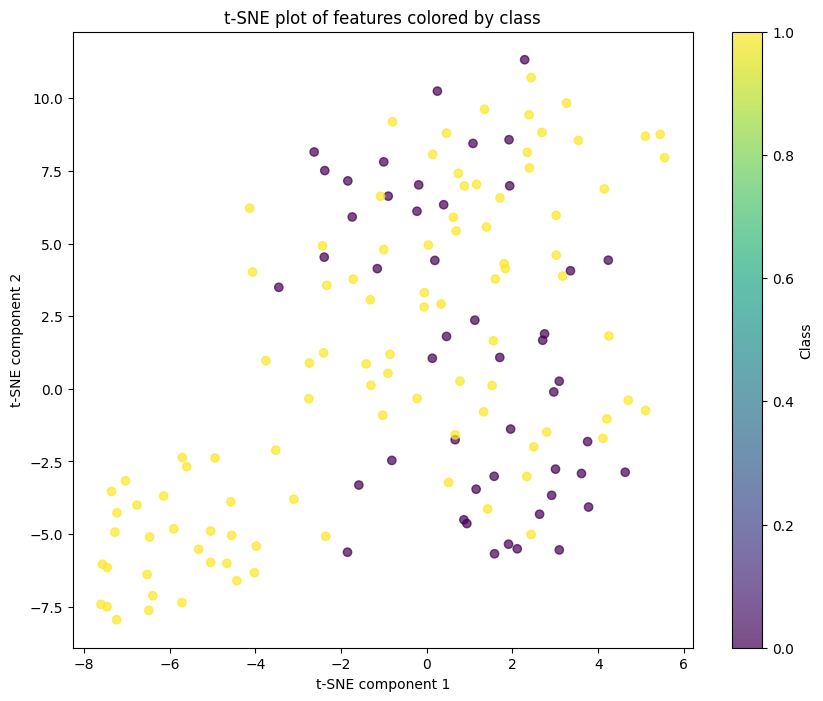

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE on the features
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

# Create the t-SNE plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title('t-SNE plot of features colored by class')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(scatter, label='Class')
plt.show()

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as nnFn
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from torch_geometric.data import Data
import random
import scipy.sparse as sp

# -------------------- Hyperparameters --------------------
num_runs = 10
num_epochs = 5000
lr = 1e-3
weight_decay = 1e-4
lambda_list = [0.05]
base_seed = 42

# -------------------- Initialize results storage --------------------
all_results = []

# -------------------- Loop over different lambda values --------------------
for lam in lambda_list:
    print(f"\n================ LAMBDA = {lam} ================\n")

    acc_scores = []
    prec_scores = []
    rec_scores = []
    f1_scores = []
    log_losses = []

    for run in range(num_runs):
        print(f"\n--- Run {run+1}/{num_runs} ---")
        torch.manual_seed(run)
        np.random.seed(run)
        random.seed(run)

        # -------------------- Initialize model and optimizer --------------------
        model = GAT(feats_dim, 512, K, device, activ, cut).to(device)
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = StepLR(optimizer, step_size=200, gamma=0.5)

        # -------------------- Training loop --------------------
        for epoch in range(num_epochs):

            # --- Augmentation for adjacency ---
            W_aug1 = aug_random_edge(W0, drop_percent=0.2, seed=epoch)  # drop edges
            W_aug2 = aug_subgraph(features, sp.csr_matrix(W0), drop_percent=0.2)[1]  # subgraph

            # --- Augmentation for features ---
            features_aug1 = aug_feature_dropout(features, drop_percent=0.2, seed=epoch)
            features_aug2 = aug_feature_dropout_cell(torch.from_numpy(features), drop_percent=0.2).numpy()

            # --- Load data for PyG ---
            node_feats1, edge_index1, _ = load_data(W_aug1, features_aug1)
            node_feats2, edge_index2, _ = load_data(W_aug2, features_aug2)
            data1 = Data(x=node_feats1, edge_index=edge_index1).to(device)
            data2 = Data(x=node_feats2, edge_index=edge_index2).to(device)

            # --- Training step ---
            model.train()
            optimizer.zero_grad()

            S1, S2, logits1, logits2, l1, l2 = model(data1, data2)

            unsup_loss = model.loss(A1, logits1)
            cont_loss = ((l1 + l2) / 2).mean()
            total_loss = unsup_loss + lam * cont_loss

            total_loss.backward()
            optimizer.step()
            scheduler.step()
            model.update_ma()

            if epoch % 500 == 0:
                print(f"Epoch {epoch} | Total: {total_loss:.4f} | Unsup: {unsup_loss:.4f} | Cont: {cont_loss:.4f}")

        # -------------------- Evaluation --------------------
        model.eval()
        with torch.no_grad():
            S1, _, logits1, _, _, _ = model(data0, data0)
            y_pred = torch.argmax(logits1, dim=1).cpu().numpy()
            y_pred_proba = nnFn.softmax(logits1, dim=1).cpu().numpy()

            acc_score = accuracy_score(y, y_pred)
            acc_score_inverted = accuracy_score(y, 1 - y_pred)
            if acc_score_inverted > acc_score:
                acc_score = acc_score_inverted
                y_pred = 1 - y_pred

            print(f"Run {run+1} Accuracy: {acc_score:.4f}")

            prec_score = precision_score(y, y_pred)
            rec_score = recall_score(y, y_pred)
            f1 = f1_score(y, y_pred)
            log_loss_value = log_loss(y, y_pred_proba)

            acc_scores.append(acc_score)
            prec_scores.append(prec_score)
            rec_scores.append(rec_score)
            f1_scores.append(f1)
            log_losses.append(log_loss_value)

    # -------------------- Store results for this lambda --------------------
    lambda_results = {
        "lambda": lam,
        "accuracy": (np.mean(acc_scores), np.std(acc_scores)),
        "precision": (np.mean(prec_scores), np.std(prec_scores)),
        "recall": (np.mean(rec_scores), np.std(rec_scores)),
        "f1": (np.mean(f1_scores), np.std(f1_scores)),
        "log_loss": (np.mean(log_losses), np.std(log_losses))
    }
    all_results.append(lambda_results)

    print(f"\n--- RESULTS FOR LAMBDA = {lam} ---")
    print(f"Accuracy: {lambda_results['accuracy'][0]:.4f} ± {lambda_results['accuracy'][1]:.4f}")
    print(f"Precision: {lambda_results['precision'][0]:.4f} ± {lambda_results['precision'][1]:.4f}")
    print(f"Recall: {lambda_results['recall'][0]:.4f} ± {lambda_results['recall'][1]:.4f}")
    print(f"F1 Score: {lambda_results['f1'][0]:.4f} ± {lambda_results['f1'][1]:.4f}")
    print(f"Log Loss: {lambda_results['log_loss'][0]:.4f} ± {lambda_results['log_loss'][1]:.4f}")

# -------------------- Final Summary --------------------
print("\n================ FINAL SUMMARY FOR ALL LAMBDAS ================\n")
print(f"{'Lambda':>8} | {'Accuracy':>18} | {'Precision':>18} | {'Recall':>18} | {'F1 Score':>18} | {'Log Loss':>18}")
print("-" * 108)
for res in all_results:
    print(f"{res['lambda']:>8} | "
          f"{res['accuracy'][0]:.4f} ± {res['accuracy'][1]:.4f} | "
          f"{res['precision'][0]:.4f} ± {res['precision'][1]:.4f} | "
          f"{res['recall'][0]:.4f} ± {res['recall'][1]:.4f} | "
          f"{res['f1'][0]:.4f} ± {res['f1'][1]:.4f} | "
          f"{res['log_loss'][0]:.4f} ± {res['log_loss'][1]:.4f}")



================ LAMBDA = 0.05 ================


--- Run 1/10 ---
Epoch 0 | Total: 0.0354 | Unsup: -0.2378 | Cont: 5.4629
Epoch 500 | Total: -0.1520 | Unsup: -0.4267 | Cont: 5.4937
Epoch 1000 | Total: -0.2153 | Unsup: -0.4901 | Cont: 5.4971
Epoch 1500 | Total: -0.2077 | Unsup: -0.4846 | Cont: 5.5377
Epoch 2000 | Total: -0.1597 | Unsup: -0.4364 | Cont: 5.5344
Epoch 2500 | Total: -0.1875 | Unsup: -0.4626 | Cont: 5.5009
Epoch 3000 | Total: -0.1889 | Unsup: -0.4642 | Cont: 5.5051
Epoch 3500 | Total: -0.2088 | Unsup: -0.4840 | Cont: 5.5032
Epoch 4000 | Total: -0.1904 | Unsup: -0.4639 | Cont: 5.4714
Epoch 4500 | Total: -0.2157 | Unsup: -0.4928 | Cont: 5.5418
Run 1 Accuracy: 0.6712

--- Run 2/10 ---
Epoch 0 | Total: 0.0350 | Unsup: -0.2365 | Cont: 5.4294
Epoch 500 | Total: -0.1923 | Unsup: -0.4713 | Cont: 5.5791
Epoch 1000 | Total: -0.2057 | Unsup: -0.4821 | Cont: 5.5274
Epoch 1500 | Total: -0.2099 | Unsup: -0.4839 | Cont: 5.4804
Epoch 2000 | Total: -0.1194 | Unsup: -0.3950 | Cont: 5.5124
E

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as nnFn
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from torch_geometric.data import Data
import random
import scipy.sparse as sp

# -------------------- Hyperparameters --------------------
num_runs = 10
num_epochs = 5000
lr = 1e-3
weight_decay = 1e-4
lambda_list = [0.001, 0.005, 0.009, 0.01, 0.05, 0.09, 0.1, 0.3, 0.5, 0.9, 1, 2, 5, 8]
base_seed = 42

# -------------------- Initialize results storage --------------------
all_results = []

# -------------------- Loop over different lambda values --------------------
for lam in lambda_list:
    print(f"\n================ LAMBDA = {lam} ================\n")

    acc_scores = []
    prec_scores = []
    rec_scores = []
    f1_scores = []
    log_losses = []

    for run in range(num_runs):
        print(f"\n--- Run {run+1}/{num_runs} ---")
        torch.manual_seed(run)
        np.random.seed(run)
        random.seed(run)

        # -------------------- Initialize model and optimizer --------------------
        model = GAT(feats_dim, 256, K, device, activ, cut).to(device)
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = StepLR(optimizer, step_size=200, gamma=0.5)

        # -------------------- Training loop --------------------
        for epoch in range(num_epochs):

            # --- Augmentation for adjacency ---
            W_aug1 = aug_random_edge(W0, drop_percent=0.2, seed=epoch)  # drop edges
            W_aug2 = aug_subgraph(features, sp.csr_matrix(W0), drop_percent=0.2)[1]  # subgraph

            # --- Augmentation for features ---
            features_aug1 = aug_feature_dropout(features, drop_percent=0.2, seed=epoch)
            features_aug2 = aug_feature_dropout_cell(torch.from_numpy(features), drop_percent=0.2).numpy()

            # --- Load data for PyG ---
            node_feats1, edge_index1, _ = load_data(W_aug1, features_aug1)
            node_feats2, edge_index2, _ = load_data(W_aug2, features_aug2)
            data1 = Data(x=node_feats1, edge_index=edge_index1).to(device)
            data2 = Data(x=node_feats2, edge_index=edge_index2).to(device)

            # --- Training step ---
            model.train()
            optimizer.zero_grad()

            S1, S2, logits1, logits2, l1, l2 = model(data1, data2)

            unsup_loss = model.loss(A1, logits1)
            cont_loss = ((l1 + l2) / 2).mean()
            total_loss = unsup_loss + lam * cont_loss

            total_loss.backward()
            optimizer.step()
            scheduler.step()
            model.update_ma()

            if epoch % 500 == 0:
                print(f"Epoch {epoch} | Total: {total_loss:.4f} | Unsup: {unsup_loss:.4f} | Cont: {cont_loss:.4f}")

        # -------------------- Evaluation --------------------
        model.eval()
        with torch.no_grad():
            S1, _, logits1, _, _, _ = model(data0, data0)
            y_pred = torch.argmax(logits1, dim=1).cpu().numpy()
            y_pred_proba = nnFn.softmax(logits1, dim=1).cpu().numpy()

            acc_score = accuracy_score(y, y_pred)
            acc_score_inverted = accuracy_score(y, 1 - y_pred)
            if acc_score_inverted > acc_score:
                acc_score = acc_score_inverted
                y_pred = 1 - y_pred

            print(f"Run {run+1} Accuracy: {acc_score:.4f}")

            prec_score = precision_score(y, y_pred)
            rec_score = recall_score(y, y_pred)
            f1 = f1_score(y, y_pred)
            log_loss_value = log_loss(y, y_pred_proba)

            acc_scores.append(acc_score)
            prec_scores.append(prec_score)
            rec_scores.append(rec_score)
            f1_scores.append(f1)
            log_losses.append(log_loss_value)

    # -------------------- Store results for this lambda --------------------
    lambda_results = {
        "lambda": lam,
        "accuracy": (np.mean(acc_scores), np.std(acc_scores)),
        "precision": (np.mean(prec_scores), np.std(prec_scores)),
        "recall": (np.mean(rec_scores), np.std(rec_scores)),
        "f1": (np.mean(f1_scores), np.std(f1_scores)),
        "log_loss": (np.mean(log_losses), np.std(log_losses))
    }
    all_results.append(lambda_results)

    print(f"\n--- RESULTS FOR LAMBDA = {lam} ---")
    print(f"Accuracy: {lambda_results['accuracy'][0]:.4f} ± {lambda_results['accuracy'][1]:.4f}")
    print(f"Precision: {lambda_results['precision'][0]:.4f} ± {lambda_results['precision'][1]:.4f}")
    print(f"Recall: {lambda_results['recall'][0]:.4f} ± {lambda_results['recall'][1]:.4f}")
    print(f"F1 Score: {lambda_results['f1'][0]:.4f} ± {lambda_results['f1'][1]:.4f}")
    print(f"Log Loss: {lambda_results['log_loss'][0]:.4f} ± {lambda_results['log_loss'][1]:.4f}")

# -------------------- Final Summary --------------------
print("\n================ FINAL SUMMARY FOR ALL LAMBDAS ================\n")
print(f"{'Lambda':>8} | {'Accuracy':>18} | {'Precision':>18} | {'Recall':>18} | {'F1 Score':>18} | {'Log Loss':>18}")
print("-" * 108)
for res in all_results:
    print(f"{res['lambda']:>8} | "
          f"{res['accuracy'][0]:.4f} ± {res['accuracy'][1]:.4f} | "
          f"{res['precision'][0]:.4f} ± {res['precision'][1]:.4f} | "
          f"{res['recall'][0]:.4f} ± {res['recall'][1]:.4f} | "
          f"{res['f1'][0]:.4f} ± {res['f1'][1]:.4f} | "
          f"{res['log_loss'][0]:.4f} ± {res['log_loss'][1]:.4f}")



================ LAMBDA = 0.001 ================


--- Run 1/10 ---
Epoch 0 | Total: -0.2322 | Unsup: -0.2377 | Cont: 5.4468
Epoch 500 | Total: -0.4742 | Unsup: -0.4798 | Cont: 5.5940
Epoch 1000 | Total: -0.4709 | Unsup: -0.4764 | Cont: 5.5169
Epoch 1500 | Total: -0.4303 | Unsup: -0.4358 | Cont: 5.5548
Epoch 2000 | Total: -0.4679 | Unsup: -0.4735 | Cont: 5.5226
Epoch 2500 | Total: -0.4563 | Unsup: -0.4618 | Cont: 5.5448
Epoch 3000 | Total: -0.4272 | Unsup: -0.4328 | Cont: 5.5498
Epoch 3500 | Total: -0.4203 | Unsup: -0.4258 | Cont: 5.5313
Epoch 4000 | Total: -0.4515 | Unsup: -0.4571 | Cont: 5.5561
Epoch 4500 | Total: -0.4554 | Unsup: -0.4609 | Cont: 5.5381
Run 1 Accuracy: 0.6712

--- Run 2/10 ---
Epoch 0 | Total: -0.2343 | Unsup: -0.2398 | Cont: 5.4828
Epoch 500 | Total: -0.4632 | Unsup: -0.4688 | Cont: 5.5992
Epoch 1000 | Total: -0.4720 | Unsup: -0.4775 | Cont: 5.5402
Epoch 1500 | Total: -0.4483 | Unsup: -0.4539 | Cont: 5.5784
Epoch 2000 | Total: -0.4626 | Unsup: -0.4682 | Cont: 5.601